In [28]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
df=pd.read_csv('/content/drive/MyDrive/라온 팀폴더/데이터셋/OBDdata/sorted_combined_file_no_duplicates.csv')

In [29]:
# 데이터 전처리
imputer = SimpleImputer(strategy='mean')  # 결측값을 평균으로 대체
#scaler = MinMaxScaler()  # 데이터 스케일링


columns = ['RPM', 'Speed', 'Load','ThrottlePos','PedalPos','FuelStatus']
df_selected = df[columns]

# 결측치 제거
df_selected = df_selected.dropna()

# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_selected)

# 전처리된 데이터를 DataFrame으로 변환
df_processed = pd.DataFrame(scaled_data, columns=columns)



In [30]:
df_processed

,RPM,Speed,Load,ThrottlePos,PedalPos,FuelStatus
0,-0.966433,-1.257105,0.612561,-0.958946,-1.040334,-0.575060
1,-0.966433,-1.257105,0.612561,-0.958946,-1.040334,-0.575060
2,-1.015058,-1.257105,0.612561,-0.958946,-1.040334,-0.499328
3,-1.015058,-1.257105,0.612561,-0.958946,-1.040334,-0.499328
4,-0.997144,-1.257105,0.612561,-0.958946,-1.040334,-0.499328
...,...,...,...,...,...,...
10601,-1.736756,-1.257105,-0.717331,-0.322768,0.134857,-0.499328
10602,-1.729078,-1.257105,-0.717331,-0.322768,-1.040334,-0.499328
10603,-1.721401,-1.257105,-0.674431,-0.322768,0.134857,-0.499328
10604,-1.729078,-1.257105,-0.717331,-0.322768,0.134857,-0.499328


In [31]:
import joblib
from sklearn.ensemble import IsolationForest

# Isolation Forest 모델 생성 및 훈련
model = IsolationForest(contamination=0.01)
model.fit(df_processed)

# 모델 가중치 저장
model_filename = 'isolation_forest_model_0817.pkl'
joblib.dump(model, model_filename)

print(f"모델이 '{model_filename}' 파일로 저장되었습니다.")


모델이 'isolation_forest_model_0817.pkl' 파일로 저장되었습니다.


In [32]:
model

IsolationForest(contamination=0.01)

In [33]:


# 새로운 데이터 불러오기
df_test = pd.read_csv('/content/simulated_double_sudden_acceleration.csv')

# 필요한 열만 선택
# columns = ['RPM', 'Speed', 'Coolant', 'Load', 'ThrottlePos', 'PedalPos', 'FuelStatus', 'FuelPressure', 'AirFlow']
df_test_selected = df_test[columns]

# 결측치 제거
df_test_selected = df_test_selected.dropna()

# 필요없는 열 제거 (예를 들어, 시간이나 비식별 데이터가 있을 경우)
# data = data.drop(columns=['column_to_drop'])

# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_test_selected)

# 전처리된 데이터를 DataFrame으로 변환
test_processed = pd.DataFrame(scaled_data, columns=columns)


# 모델에 데이터 적용 및 이상치 예측
test_processed['anomaly'] = model.predict(test_processed)

# 이상치 탐지 결과: -1은 이상치, 1은 정상 데이터
test_processed['anomaly'] = test_processed['anomaly'].map({1: 0, -1: 1})

# 이상치 데이터만 선택
anomalies = test_processed[test_processed['anomaly'] == 1]

# 결과 확인
anomalies.head()


,RPM,Speed,Load,ThrottlePos,PedalPos,FuelStatus,anomaly
300,3.456068,2.289573,-0.729016,3.914263,3.843547,-0.463078,1
301,3.407242,2.169225,0.544374,3.914263,3.843547,-0.463078,1
302,3.556336,2.229399,-0.389445,3.914263,3.843547,-0.463078,1
303,3.490072,2.259486,-0.729016,3.914263,3.843547,-0.463078,1
304,3.462172,2.259486,-0.686569,3.914263,3.843547,2.146186,1


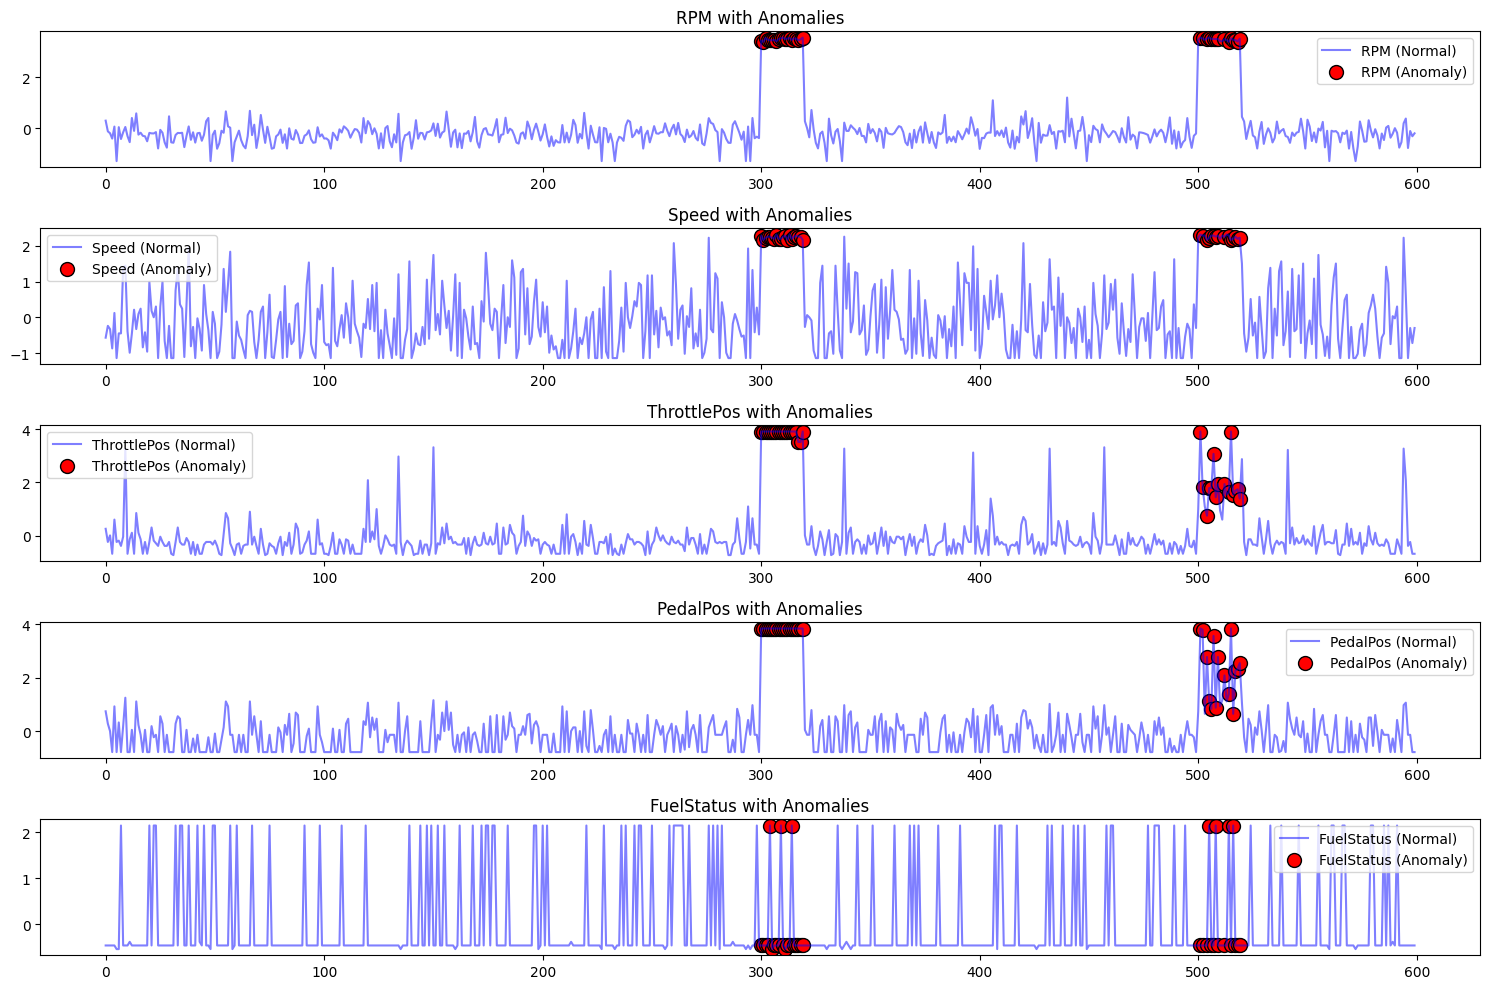

In [34]:
import matplotlib.pyplot as plt

# 각 피처에 대해 시각화 (예: RPM, Speed, Load)
plt.figure(figsize=(15, 10))

for i, column in enumerate(['RPM', 'Speed', 'ThrottlePos', 'PedalPos', 'FuelStatus']):
    plt.subplot(5, 1, i+1)
    plt.plot(test_processed[column], label=f'{column} (Normal)', color='blue', alpha=0.5)

    # 이상치만 따로 표시
    if not anomalies.empty:
        plt.scatter(anomalies.index, anomalies[column], color='red', label=f'{column} (Anomaly)', s=100, edgecolors='black')

    plt.title(f'{column} with Anomalies')
    plt.legend()

plt.tight_layout()
plt.show()
